# Recompra Bázica

In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as go 
from sklearn.cluster import KMeans

# Evitar exibir Warnings
import warnings
warnings.filterwarnings("ignore")


## Base de dados

In [63]:
base_compras = pd.read_csv('data-set/vendas_de_produtos.csv', dtype={'ID_Cliente': 'Int64', 'ID_Produto': 'Int64'}, parse_dates=["Data"])

In [64]:
base_clientes = pd.read_csv('data-set/clientes.csv', dtype={'ID_Cliente': 'Int64'})

### Exploração dos dados 

In [65]:
base_compras

,ID_Cliente,Data,ID_Produto,Descrição_Produto,Quantidade,Preço_Unitário,ID_Pedido,Desconto,Frete,Total_do_Pedido
0,12429082030,2021-05-27,14,Bázica Gola C - Air - Azul Marinho - M,1,109.0,1000000401,0.0,4.90,113.90
1,12793619292,2021-05-27,<NA>,Bázica Gola C - Powerful - Preto - P,1,109.0,1000000400,0.0,4.90,113.90
2,1,2021-05-27,<NA>,Bázica Gola C - Powerful - Preto - M,1,109.0,1000000399,0.0,4.90,113.90
3,2,2021-05-26,<NA>,Bázica Gola C - Powerful - Preto - M,2,109.0,1000000398,0.0,4.90,301.90
4,2,2021-05-26,<NA>,Bázica Gola C - Powerful - Branco - M,1,109.0,1000000398,0.0,4.90,301.90
...,...,...,...,...,...,...,...,...,...,...
17023,15990665892,2022-12-31,2,Bázica Gola C - Preta - Powerful - M,1,119.0,9017,0.0,21.19,140.19
17024,15896646324,2022-12-31,192,Bázica Vibe - Azul Cobalto - Viscose - M,1,223.0,9018,0.0,0.00,223.00
17025,12268398905,2022-12-31,211,Bázica Lord - Branca - Pima - GG,1,247.0,9019,0.0,0.00,247.00
17026,15990672946,2022-12-31,461,Bázica Long - Ocean - Air - G,1,119.0,9020,23.8,0.00,214.20


**Verificando Informações da Base de Dados**

In [66]:
base_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17028 entries, 0 to 17027
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID_Cliente         17026 non-null  Int64         
 1   Data               17028 non-null  datetime64[ns]
 2   ID_Produto         16625 non-null  Int64         
 3   Descrição_Produto  17028 non-null  object        
 4   Quantidade         17028 non-null  int64         
 5   Preço_Unitário     16804 non-null  float64       
 6   ID_Pedido          17028 non-null  int64         
 7   Desconto           16984 non-null  float64       
 8   Frete              17028 non-null  float64       
 9   Total_do_Pedido    17028 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 1.3+ MB


**Verificando a soma de dados ausentes em cada coluna**

In [67]:
base_compras.isnull().sum()

ID_Cliente             2
Data                   0
ID_Produto           403
Descrição_Produto      0
Quantidade             0
Preço_Unitário       224
ID_Pedido              0
Desconto              44
Frete                  0
Total_do_Pedido        0
dtype: int64

In [68]:
np.round(base_compras.isnull().sum()['ID_Cliente']/ base_compras.shape[0] * 100, 2)

0.01

Como é percebido, existem dois pedidos com id de cliente nulos que equivalem a $0.01$%, então irei analisar se existem outros pedidos de venda com o mesmo código do pedido para subtituir o ID de cliente nulo desses pedidos,  caso contrário irei optar por remover esses dados devido que a quantidade pedidos não irá influenciar tanto no resultado final.

**Verificando os ID de Clientes Nulos**

In [69]:
base_compras[base_compras['ID_Cliente'].isnull()]

,ID_Cliente,Data,ID_Produto,Descrição_Produto,Quantidade,Preço_Unitário,ID_Pedido,Desconto,Frete,Total_do_Pedido
483,<NA>,2020-09-10,<NA>,Bázica Gola C - Powerful - Branco - G,1,NaN,1000000044,0.0,0.0,109.0
485,<NA>,2020-08-30,<NA>,Bázica Gola C - Powerful - Preto - GG,1,NaN,1000000039,0.0,0.0,197.0


**Verificando se existem outra venda com número de pedido igual**

In [70]:
base_compras[base_compras['ID_Pedido'] == 1000000044]

,ID_Cliente,Data,ID_Produto,Descrição_Produto,Quantidade,Preço_Unitário,ID_Pedido,Desconto,Frete,Total_do_Pedido
483,<NA>,2020-09-10,<NA>,Bázica Gola C - Powerful - Branco - G,1,NaN,1000000044,0.0,0.0,109.0


In [71]:
base_compras[base_compras['ID_Pedido'] == 1000000039]

,ID_Cliente,Data,ID_Produto,Descrição_Produto,Quantidade,Preço_Unitário,ID_Pedido,Desconto,Frete,Total_do_Pedido
485,<NA>,2020-08-30,<NA>,Bázica Gola C - Powerful - Preto - GG,1,NaN,1000000039,0.0,0.0,197.0


**Como não existe outra venda com mesmo código de pedido essas linhas serão removidas**  

In [72]:
base_compras = base_compras.dropna(subset=['ID_Cliente'])
base_compras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17026 entries, 0 to 17027
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID_Cliente         17026 non-null  Int64         
 1   Data               17026 non-null  datetime64[ns]
 2   ID_Produto         16625 non-null  Int64         
 3   Descrição_Produto  17026 non-null  object        
 4   Quantidade         17026 non-null  int64         
 5   Preço_Unitário     16804 non-null  float64       
 6   ID_Pedido          17026 non-null  int64         
 7   Desconto           16982 non-null  float64       
 8   Frete              17026 non-null  float64       
 9   Total_do_Pedido    17026 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 1.5+ MB


**Verificando os dtypes das colunas**

In [73]:
base_compras.dtypes

ID_Cliente                    Int64
Data                 datetime64[ns]
ID_Produto                    Int64
Descrição_Produto            object
Quantidade                    int64
Preço_Unitário              float64
ID_Pedido                     int64
Desconto                    float64
Frete                       float64
Total_do_Pedido             float64
dtype: object

**Informações sobre as datas**

In [74]:
base_compras.head()

,ID_Cliente,Data,ID_Produto,Descrição_Produto,Quantidade,Preço_Unitário,ID_Pedido,Desconto,Frete,Total_do_Pedido
0,12429082030,2021-05-27,14,Bázica Gola C - Air - Azul Marinho - M,1,109.0,1000000401,0.0,4.9,113.9
1,12793619292,2021-05-27,<NA>,Bázica Gola C - Powerful - Preto - P,1,109.0,1000000400,0.0,4.9,113.9
2,1,2021-05-27,<NA>,Bázica Gola C - Powerful - Preto - M,1,109.0,1000000399,0.0,4.9,113.9
3,2,2021-05-26,<NA>,Bázica Gola C - Powerful - Preto - M,2,109.0,1000000398,0.0,4.9,301.9
4,2,2021-05-26,<NA>,Bázica Gola C - Powerful - Branco - M,1,109.0,1000000398,0.0,4.9,301.9


In [75]:
pd.DataFrame(base_compras.Data.describe())

,Data
count,17026
unique,636
top,2022-10-14 00:00:00
freq,484
first,2020-08-19 00:00:00
last,2022-12-31 00:00:00


Vemos que as compras online foram feitas no perido de 19-08-2020 a 31-12-2022

# <font color="red"> Se der tempo Fazer analise inicial com outro dataset </font>

### Prevendo compra do cliente



O objetivo desta seção é criar um modelo usando o dataframe df_data fornecido, para estimar se um determinado cliente comprará algo novamente na loja online.

O dataframe é dividido em dois:

   * O primeiro sub-dataframe atribuído à variável Python cliente_comp_dt contém compras feitas por clientes de 19-08-2020 a 30-09-2022. Este dataframe será usado para estudar as compras comportamentais dos clientes online.

   * O segundo sub-dataframe atribuído à variável Python cliente_prox_tri será usado para estudar as compras comportamentais dos clientes no próximo trimestre. Ou seja, de 01-10-2022 a 31-12-2022, com ênfase de localizar os clientes que irão comprar no período **01-01-2023** e **14-01-2023**.


In [76]:
cliente_comp_dt = base_compras[(base_compras.Data < pd.Timestamp(2022, 10, 1)) & 
                               (base_compras.Data >= pd.Timestamp(2020, 8, 19))].reset_index(drop=True)

cliente_prox_tri = base_compras[(base_compras.Data < pd.Timestamp(2023,1,1)) & 
                                (base_compras.Data >= pd.Timestamp(2022, 10, 1))].reset_index(drop=True)

In [77]:
# Obtenha os clientes distintos no dataframe cliente_comp_dt
dados_clientes = pd.DataFrame(cliente_comp_dt['ID_Cliente'].unique())
# Renomeio a Coluna para ID_Cliente 
dados_clientes.columns = ['ID_Cliente']

Agora vamos encontrar a primeira compra feita por cada cliente no próximo trimestre.

In [78]:
# Criei um dataframe com Id do Cliente e a primeira data de compra do cliente em cliente_prox_tri 
cliente_1_cmp_tri = cliente_prox_tri.groupby('ID_Cliente').Data.min().reset_index()
cliente_1_cmp_tri.columns =  ['ID_Cliente', 'PrimeiraDataCompraTrimestre']
cliente_1_cmp_tri.head()

,ID_Cliente,PrimeiraDataCompraTrimestre
0,12268398905,2022-10-05
1,12378697829,2022-12-16
2,12383774078,2022-10-06
3,12384988715,2022-10-29
4,12385092320,2022-10-14


E então, agora vamos encontrar a última compra feita por cada cliente no dataframe cliente_comp_dt.

In [79]:
cliente_ult_cmp = cliente_comp_dt.groupby('ID_Cliente').Data.max().reset_index()
cliente_ult_cmp.columns = ['ID_Cliente', 'UltDataCompraAnteriorAoTrismestre']
cliente_ult_cmp

,ID_Cliente,UltDataCompraAnteriorAoTrismestre
0,1,2021-05-27
1,2,2021-05-26
2,3,2021-05-17
3,4,2021-05-17
4,5,2021-05-16
...,...,...
2443,15889151369,2022-09-30
2444,15889169723,2022-09-30
2445,15889184513,2022-09-30
2446,15889232166,2022-09-30


Vamos mesclar os dois dataframes cliente_ult_cmp e cliente_1_cmp_tri. 

In [80]:
clientes_data_compras = pd.merge(cliente_ult_cmp, cliente_1_cmp_tri, on='ID_Cliente', how='left')

In [81]:
clientes_data_compras.head()

,ID_Cliente,UltDataCompraAnteriorAoTrismestre,PrimeiraDataCompraTrimestre
0,1,2021-05-27,NaT
1,2,2021-05-26,NaT
2,3,2021-05-17,NaT
3,4,2021-05-17,NaT
4,5,2021-05-16,NaT


Vamos calcular a diferença de tempo em dias entre a última compra do cliente no dataframe cliente_ult_cmp e a primeira compra no dataframe cliente_1_cmp_tri.

In [82]:
clientes_data_compras['ProximoDiaCompra'] = (clientes_data_compras['PrimeiraDataCompraTrimestre'] -
                                             clientes_data_compras['UltDataCompraAnteriorAoTrismestre']).dt.days

clientes_data_compras.head()

,ID_Cliente,UltDataCompraAnteriorAoTrismestre,PrimeiraDataCompraTrimestre,ProximoDiaCompra
0,1,2021-05-27,NaT,NaN
1,2,2021-05-26,NaT,NaN
2,3,2021-05-17,NaT,NaN
3,4,2021-05-17,NaT,NaN
4,5,2021-05-16,NaT,NaN


In [83]:
# Mescla com dados_clientes
dados_clientes = pd.merge(dados_clientes, clientes_data_compras[['ID_Cliente', 'ProximoDiaCompra']], on='ID_Cliente', how='left')
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra
0,12429082030,NaN
1,12793619292,NaN
2,1,NaN
3,2,NaN
4,12732289533,27.0


Irei atualizar o dataframe dados_clientes preenchendo todos os valores ausentes com 9999

In [84]:
dados_clientes = dados_clientes.fillna(9999)
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra
0,12429082030,9999.0
1,12793619292,9999.0
2,1,9999.0
3,2,9999.0
4,12732289533,27.0


Em seguida, definiremos alguns recursos e os adicionaremos ao dataframe dados_clientes para construir nosso modelo de aprendizado de máquina. Usaremos o método de segmentação Recência - Frequência - Valor Monetário. Ou seja, vamos colocar os clientes em grupos com base no seguinte:

   *  Recência: o comportamento de compra dos clientes com base na data de compra mais recente e quantos dias eles ficaram inativos desde a última compra.

   *  Frequência: Comportamento de compra dos clientes com base no número de vezes que compram na loja de varejo online.

   *  Valor/receita monetária: comportamento de compra dos clientes com base na receita que geram.

Depois, aplicaremos o agrupamento de K-means para atribuir aos clientes uma pontuação para cada um dos recursos.


**Recência**

Vamos encontrar a data de compra mais recente de cada cliente e ver quantos dias ele está inativo. Depois, podemos aplicar o agrupamento de K-means para atribuir aos clientes uma pontuação de recência

In [85]:
cliente_compra_recente = cliente_comp_dt.groupby('ID_Cliente').Data.max().reset_index()
cliente_compra_recente.columns = ['ID_Cliente', 'CompraMaisRecente']
cliente_compra_recente.head()

,ID_Cliente,CompraMaisRecente
0,1,2021-05-27
1,2,2021-05-26
2,3,2021-05-17
3,4,2021-05-17
4,5,2021-05-16


In [86]:
# Encontrando a Recência em Dias
cliente_compra_recente['Recencia'] = (cliente_compra_recente['CompraMaisRecente'].max() - 
                                      cliente_compra_recente['CompraMaisRecente']).dt.days

# Mescle os dataframes dados_clientes e cliente_compra_recente[['ID_Cliente', 'Recencia']] na coluna CustomerID. 
dados_clientes = pd.merge(dados_clientes, cliente_compra_recente[['ID_Cliente', 'Recencia']], on='ID_Cliente')
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia
0,12429082030,9999.0,490
1,12793619292,9999.0,100
2,1,9999.0,491
3,2,9999.0,492
4,12732289533,27.0,13


In [87]:
pd.DataFrame(dados_clientes.Recencia.describe())

,Recencia
count,2448.000000
mean,160.996732
std,154.353439
min,0.000000
25%,50.000000
50%,109.000000
75%,256.250000
max,772.000000


A recência média é de aproximadamente 161 dias, enquanto a mediana é de 109 dias.

In [88]:
hist_fig = px.histogram(dados_clientes, 
                        x="Recencia", 
                        title="Recência dos clientes em dias"                      
)

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Recência em grupos de 20 dias", 
                       yaxis_title="Número de clientes"
)

hist_fig.show(config={'displaylogo': False})

No passo seguinte, irei aplicar o agrupamento K-means para atribuir uma pontuação de recência. No entanto, precisamos saber quantos clusters para usar o algoritmo K-means. Aplicaremos o método Elbow para determinar quantos clusters precisaremos. O método Elbow simplesmente informa o número de cluster ideal para a inércia ideal. 

In [89]:
my_dict = {}
cliente_recencia = dados_clientes[['Recencia']]

for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(cliente_recencia)
    cliente_recencia['clusters'] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_
    
line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Número de cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

In [90]:
numero_de_clusters = 4
kmeans = KMeans(n_clusters=numero_de_clusters)
kmeans.fit(dados_clientes[['Recencia']])
dados_clientes['RecenciaCluster'] = kmeans.predict(dados_clientes[['Recencia']])
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster
0,12429082030,9999.0,490,2
1,12793619292,9999.0,100,0
2,1,9999.0,491,2
3,2,9999.0,492,2
4,12732289533,27.0,13,3


In [91]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final


In [92]:
dados_clientes = order_cluster(dados_clientes, 'Recencia', 'RecenciaCluster', False)
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster
0,12429082030,9999.0,490,0
1,1,9999.0,491,0
2,2,9999.0,492,0
3,12628027616,9999.0,500,0
4,3,9999.0,501,0


In [93]:
#Imprima características do cluster
dados_clientes.groupby('RecenciaCluster')['Recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,143.0,591.657343,90.296078,455.0,507.0,613.0,672.0,772.0
1,509.0,315.532417,52.813942,226.0,280.0,290.0,346.0,452.0
2,832.0,134.960337,39.770819,87.0,102.0,121.0,163.0,225.0
3,964.0,37.987552,24.593515,0.0,14.0,41.5,57.0,86.0


Observe acima que 3 cobre os clientes mais recentes, enquanto 0 tem os clientes mais inativos. 

**Frequência**

Em seguida,encontraremos o comportamento de compra dos clientes com base no número de vezes que compram na loja 
online. Ou seja, o número total de pedidos de cada cliente.

In [94]:
#Obtém contagens de pedidos para cada usuário e criar um dataframe com esse conteúdo
cliente_frequencia = base_compras.groupby('ID_Cliente').Data.count().reset_index()
cliente_frequencia.columns = ['ID_Cliente','Frequencia']
cliente_frequencia

,ID_Cliente,Frequencia
0,1,1
1,2,2
2,3,1
3,4,2
4,5,1
...,...,...
3778,15990633555,2
3779,15990637791,2
3780,15990645865,2
3781,15990665892,1


In [95]:
#Adiciono esses dados ao nosso dados_clientes principal
dados_clientes = pd.merge(dados_clientes, cliente_frequencia, on='ID_Cliente')
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia
0,12429082030,9999.0,490,0,6
1,1,9999.0,491,0,1
2,2,9999.0,492,0,2
3,12628027616,9999.0,500,0,1
4,3,9999.0,501,0,1


In [96]:
pd.DataFrame(dados_clientes.Frequencia.describe())

,Frequencia
count,2448.000000
mean,5.534722
std,6.507141
min,1.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,86.000000


In [97]:
kmeans = KMeans(n_clusters=numero_de_clusters)
kmeans.fit(dados_clientes[['Frequencia']])
dados_clientes['FrequenciaCluster'] = kmeans.predict(dados_clientes[['Frequencia']])

In [98]:
dados_clientes = order_cluster(dados_clientes, 'Frequencia', 'FrequenciaCluster', False)
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster
0,12429082030,9999.0,490,0,6,2
1,12443818670,9999.0,473,0,6,2
2,12429451836,9999.0,485,0,5,2
3,12478497882,567.0,511,0,7,2
4,12528879531,576.0,507,0,5,2


In [99]:
# Ver detalhes de cada FrequenciaCluster
dados_clientes.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,55.0,33.727273,10.124145,26.0,27.0,31.0,36.5,86.0
1,194.0,16.989691,3.315827,13.0,14.0,16.0,19.0,25.0
2,680.0,7.751471,2.229471,5.0,6.0,7.0,9.0,12.0
3,1519.0,2.058591,1.062533,1.0,1.0,2.0,3.0,4.0


Como foi o caso da Recência, maior número de frequência significa melhores clientes

**Receita**

In [100]:
cliente_pedidos_total = base_compras.groupby(by=['ID_Cliente', 'ID_Pedido']).Total_do_Pedido.mean().reset_index()
cliente_receita = cliente_pedidos_total.groupby('ID_Cliente').Total_do_Pedido.sum().reset_index()

In [101]:
# Mescle-o com o nosso dados_clientes
dados_clientes = pd.merge(dados_clientes, cliente_receita, on='ID_Cliente')
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Total_do_Pedido
0,12429082030,9999.0,490,0,6,2,623.40
1,12443818670,9999.0,473,0,6,2,727.73
2,12429451836,9999.0,485,0,5,2,386.14
3,12478497882,567.0,511,0,7,2,958.50
4,12528879531,576.0,507,0,5,2,569.90


In [102]:
# Aplicando agrupamento
kmeans = KMeans(n_clusters=numero_de_clusters)
kmeans.fit(dados_clientes[['Total_do_Pedido']])
dados_clientes['TotalPedidoCluster'] = kmeans.predict(dados_clientes[['Total_do_Pedido']])

In [103]:
# Ordenando os números do cluster
dados_clientes = order_cluster(dados_clientes, 'Total_do_Pedido', 'TotalPedidoCluster', True)
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Total_do_Pedido,TotalPedidoCluster
0,12429082030,9999.0,490,0,6,2,623.40,0
1,12429451836,9999.0,485,0,5,2,386.14,0
2,12528879531,576.0,507,0,5,2,569.90,0
3,12920724665,564.0,479,0,6,2,638.30,0
4,13148663300,482.0,468,0,6,2,588.83,0


In [104]:
# Mostrarndo detalhes do dataframe
dados_clientes.groupby('TotalPedidoCluster')['Total_do_Pedido'].describe()

,count,mean,std,min,25%,50%,75%,max
TotalPedidoCluster,,,,,,,,
0,1721.0,274.236729,165.961921,0.0,119.01,238.00,376.00,672.00
1,573.0,1070.700489,305.723094,675.0,803.00,1013.89,1300.88,1785.95
2,129.0,2510.312946,507.539641,1797.0,2098.00,2370.41,2894.24,3892.70
3,25.0,5340.499600,1466.003006,4124.0,4559.20,4998.00,5405.80,11313.90


**Pontuação Geral**  
Agora iremos finalmente somar os recursos do cluster

In [105]:
# Calcule a pontuação geral e use mean() para ver os detalhes
dados_clientes['PontuacaoGeral'] = dados_clientes['RecenciaCluster'] + dados_clientes['FrequenciaCluster'] + dados_clientes['TotalPedidoCluster']
dados_clientes.groupby('PontuacaoGeral')['Recencia', 'Frequencia', 'Total_do_Pedido'].mean()

,Recencia,Frequencia,Total_do_Pedido
PontuacaoGeral,,,
2,420.166667,10.333333,467.761667
3,510.402062,3.778351,363.955876
4,276.728723,3.992908,430.624858
5,117.842225,5.793417,642.819342
6,40.469773,6.730479,812.174244
7,61.555556,6.000000,1704.336667


A pontuação acima nos mostra claramente que os clientes com pontuação

In [106]:
dados_clientes['Segmento'] = 'Baixo-Valor'
dados_clientes.loc[dados_clientes['PontuacaoGeral'] > 4, 'Segmento'] = "Valor-Médio"
dados_clientes.loc[dados_clientes['PontuacaoGeral'] > 6, 'Segmento'] = 'Valor-Alto'

In [107]:
dados_clientes.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Total_do_Pedido,TotalPedidoCluster,PontuacaoGeral,Segmento
0,12429082030,9999.0,490,0,6,2,623.40,0,2,Baixo-Valor
1,12429451836,9999.0,485,0,5,2,386.14,0,2,Baixo-Valor
2,12528879531,576.0,507,0,5,2,569.90,0,2,Baixo-Valor
3,12920724665,564.0,479,0,6,2,638.30,0,2,Baixo-Valor
4,13148663300,482.0,468,0,6,2,588.83,0,2,Baixo-Valor


Agora irei criar uma cópia do dataframe dados_clientes e aplicar o método **get_dummies** a ele para converter todas as colunas categóricas de Segmento em variáveis indicadoras.


In [108]:
# Cria dados_clientes_class como uma cópia de dados_clientes antes de aplicar get_dummies
dados_clientes_class = dados_clientes.copy()
dados_clientes_class = pd.get_dummies(dados_clientes_class)
dados_clientes_class.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Total_do_Pedido,TotalPedidoCluster,PontuacaoGeral,Segmento_Baixo-Valor,Segmento_Valor-Alto,Segmento_Valor-Médio
0,12429082030,9999.0,490,0,6,2,623.40,0,2,1,0,0
1,12429451836,9999.0,485,0,5,2,386.14,0,2,1,0,0
2,12528879531,576.0,507,0,5,2,569.90,0,2,1,0,0
3,12920724665,564.0,479,0,6,2,638.30,0,2,1,0,0
4,13148663300,482.0,468,0,6,2,588.83,0,2,1,0,0


Como nosso objetivo é estimar se um cliente fará uma compra nas próximas duas semanas, criaremos uma nova coluna NextPurchaseDayRange com valores como 1 ou 0 definidos da seguinte forma:
    
   * Se o valor for 1, então indica que o cliente vai comprar algo nas próximas 2 semanas, ou seja, 14 dias a partir da última compra.   
   
   * O valor 0 indica que o cliente comprará algo em mais de 14 dias a partir de sua última compra.


In [126]:
dados_clientes_class['NextPurchaseDayRange'] = 1 # Menos de 14 dias
dados_clientes_class.loc[dados_clientes_class.ProximoDiaCompra > 14, 'NextPurchaseDayRange'] = 0 # maior de 14 dias
dados_clientes_class.head()

,ID_Cliente,ProximoDiaCompra,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Total_do_Pedido,TotalPedidoCluster,PontuacaoGeral,Segmento_Baixo-Valor,Segmento_Valor-Alto,Segmento_Valor-Médio,NextPurchaseDayRange
0,12429082030,9999.0,490,0,6,2,623.40,0,2,1,0,0,0
1,12429451836,9999.0,485,0,5,2,386.14,0,2,1,0,0,0
2,12528879531,576.0,507,0,5,2,569.90,0,2,1,0,0,0
3,12920724665,564.0,479,0,6,2,638.30,0,2,1,0,0,0
4,13148663300,482.0,468,0,6,2,588.83,0,2,1,0,0,0


Finalmente nesta seção, vamos ver a correlação entre nossos recursos e rótulo. Podemos conseguir isso aplicando o método corr ao dataframe dados_clientes_class.

In [135]:
corr_matriz = dados_clientes_class[dados_clientes_class.columns].corr()
corr_df = pd.DataFrame(corr_matriz.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matriz[corr_matriz < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
ID_Cliente,-0.706256,0.551922
ProximoDiaCompra,-0.503995,0.531723
Recencia,-0.930607,0.769024
RecenciaCluster,-0.930607,0.916696
Frequencia,-0.903294,0.937441
FrequenciaCluster,-0.903294,0.531723
Total_do_Pedido,-0.838168,0.937441
TotalPedidoCluster,-0.855183,0.892710
PontuacaoGeral,-0.853556,0.916696
Segmento_Baixo-Valor,-0.991501,0.769024


Na saída acima, observamos que a Total_do_Pedido e Frequencia tem a maior correlação positiva de 0,94, e com Segmento_Baixo-Valor e Segmento_Valor-Médio tem a maior correlação negativa de -0,99.

Podemos obter uma boa visualização da matriz de coeficientes abaixo.

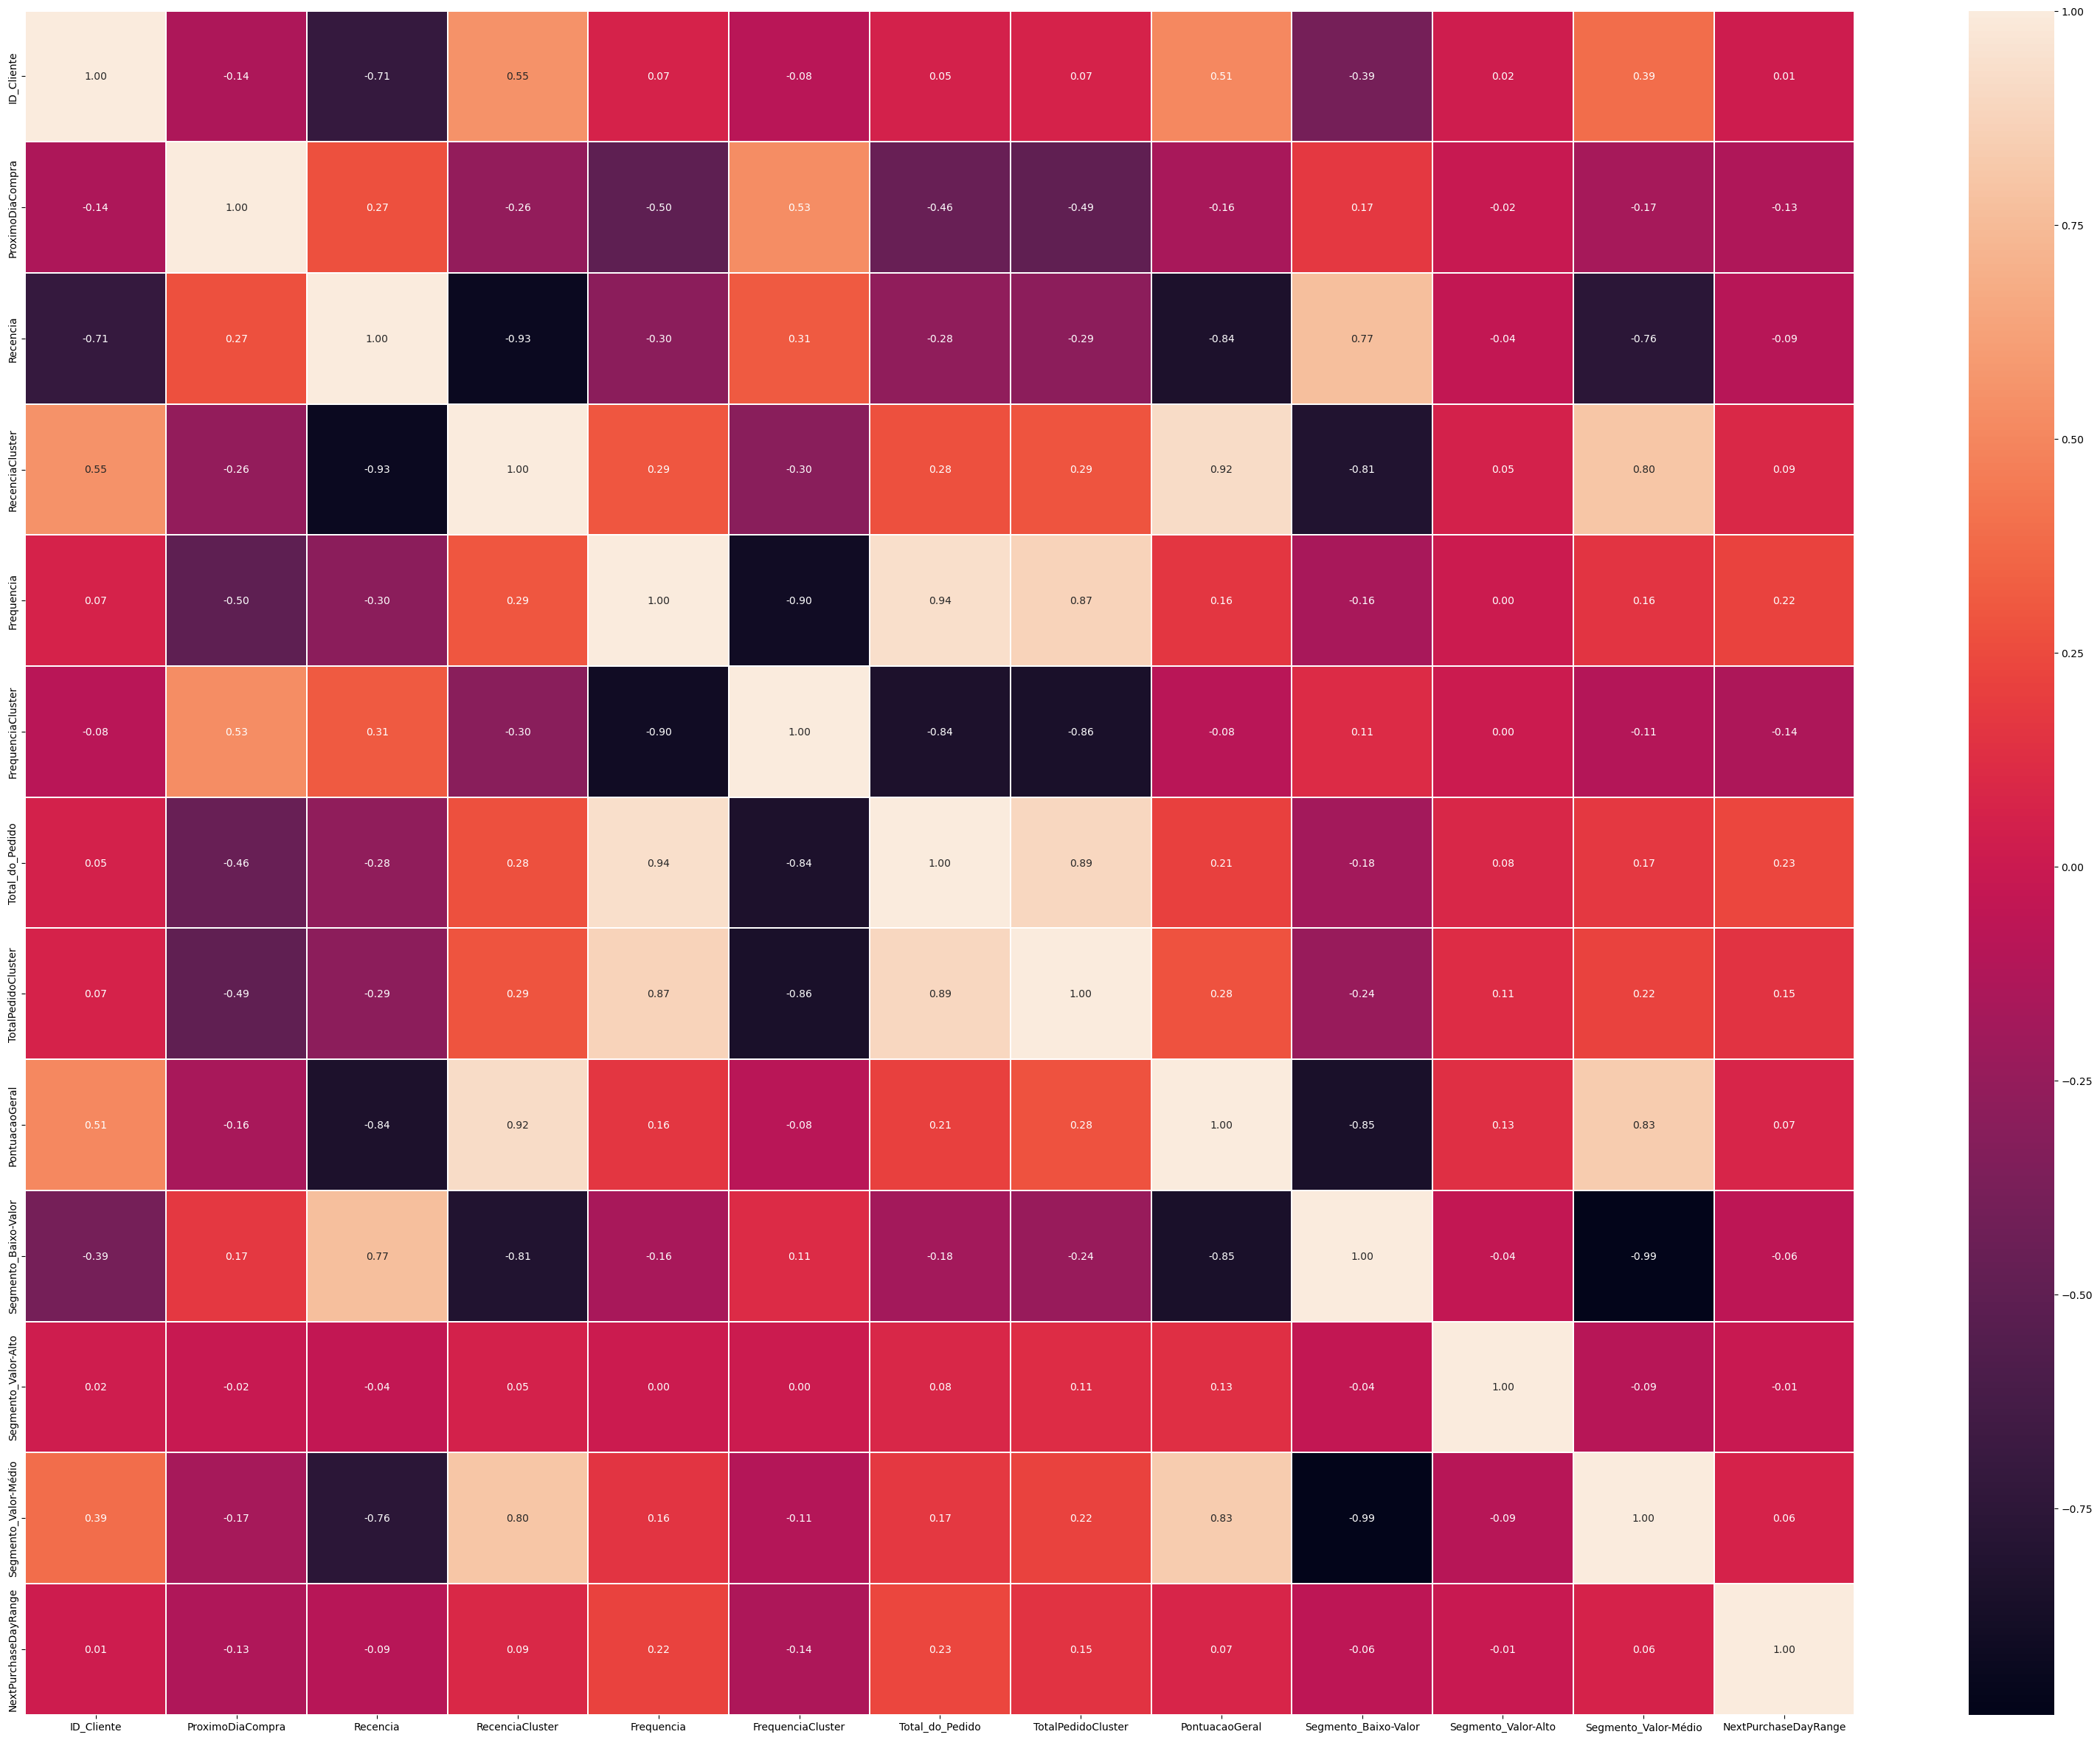

In [136]:
plt.figure(figsize = (40, 30))
sns.heatmap(corr_matriz, annot = True, linewidths=0.2, fmt=".2f");

### Construindo modelo de aprendizado de máquina

In [137]:
dados_clientes_class = dados_clientes_class.drop('ProximoDiaCompra', axis=1)
dados_clientes_class

,ID_Cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Total_do_Pedido,TotalPedidoCluster,PontuacaoGeral,Segmento_Baixo-Valor,Segmento_Valor-Alto,Segmento_Valor-Médio,NextPurchaseDayRange
0,12429082030,490,0,6,2,623.40,0,2,1,0,0,0
1,12429451836,485,0,5,2,386.14,0,2,1,0,0,0
2,12528879531,507,0,5,2,569.90,0,2,1,0,0,0
3,12920724665,479,0,6,2,638.30,0,2,1,0,0,0
4,13148663300,468,0,6,2,588.83,0,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2443,15662353010,1,3,41,0,4559.20,3,6,0,0,1,0
2444,15692298038,1,3,35,0,5370.00,3,6,0,0,1,0
2445,15758948769,0,3,29,0,4124.00,3,6,0,0,1,1
2446,15762013256,11,3,27,0,4230.41,3,6,0,0,1,0
